In [ ]:
# !pip install -U git+https://github.com/albu/albumentations

In [ ]:
from google.colab import drive
import os
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Utils")

In [ ]:

from torch.utils.data import Dataset, random_split
import math
from PIL import Image
import cv2
import numpy as np
import torch
import os
from tqdm import notebook
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
import time
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo, CustomDataSet, CustomTrainDataSet, get_train_test_data
from dataloader import DataLoader
from models.unet import UNet
from albumentation import Albumentation
from transforms import Transform
from train import Train
from test import Test
from plot import Plot, display_results
import matplotlib.pyplot as plt




### Create model and display summary

In [ ]:
model_obj = UNet(n_channels = 6,n_classes = 1)

device = HelperModel.get_device()

model = model_obj.to(device)


helper_obj = HelperModel(model)


helper_obj.display_model_summay(model, (6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,760
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
        DoubleConv-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,248
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

### Transforms

In [ ]:
input_img_means = (0.5558092594146729, 0.5201340913772583, 0.463156521320343, 0.5455222129821777, 0.5086212158203125, 0.45718181133270264)
input_img_std = (0.2149990200996399, 0.21596555411815643, 0.23049025237560272, 0.22610004246234894, 0.2249932438135147, 0.23590309917926788)
mask_means = (0.05790501832962036)
mask_std =  (0.22068527340888977)
depth_means = (0.40361160039901733)
depth_std = (0.19922664761543274)

In [ ]:
input_transforms_data = [A.Resize(64,64), A.Normalize(mean=input_img_means, std=input_img_std), AP.ToTensor() ]
mask_transform_data = [A.Resize(64,64), A.Normalize(mean=mask_means, std=mask_std), A.Transpose(always_apply=True), AP.ToTensor() ]
depth_transform_data = [A.Resize(64,64), A.Normalize(mean=depth_means, std=depth_std), A.Transpose(always_apply=True), AP.ToTensor() ]

input_transforms = Albumentation(transforms = input_transforms_data)
mask_transforms = Albumentation(transforms = mask_transform_data)
depth_transforms = Albumentation(transforms = depth_transform_data)

transforms = {
    "input" : input_transforms,
    "mask": mask_transforms,
    "depth" : depth_transforms
}



### Get Train, Test Dataset

In [ ]:

train_dataset, test_dataset = get_train_test_data(start_no = 1, end_no = 11, train_transforms = transforms, test_transforms = transforms)
print(len(train_dataset))
print(len(test_dataset))

28000
12000


In [ ]:
input_img, fg_bg_masks, fg_bg_depth = train_dataset[0]

In [ ]:
input_img.shape




torch.Size([6, 64, 64])

In [ ]:
fg_bg_masks

tensor([[-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        ...,
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624]])

In [ ]:
fg_bg_depth

tensor([[-0.9433, -1.0614, -1.0417,  ...,  0.3756,  0.2574,  0.1393],
        [-1.0220, -1.0614, -1.0811,  ...,  0.3952,  0.2968,  0.1197],
        [-1.0023, -1.0614, -1.0811,  ...,  0.4543,  0.3559,  0.2181],
        ...,
        [-0.9826, -1.0811, -1.1007,  ..., -1.0811, -1.1007, -1.0220],
        [-0.9826, -1.1007, -1.1007,  ..., -1.1204, -1.1204, -1.1007],
        [-1.0220, -1.0811, -1.0811,  ..., -1.1204, -1.1007, -1.0811]])

In [ ]:
img1,mask,depth = test_dataset[0]

In [ ]:
img1.shape

torch.Size([6, 64, 64])

In [ ]:
mask.shape

torch.Size([64, 64])

In [ ]:
depth.shape

torch.Size([64, 64])

### Get Data Loader

In [ ]:
data_loader_obj = DataLoader(train_dataset, test_dataset, batch_size=8)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Model Training

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR


lr=0.01
EPOCHS = 15
train_obj = Train()
test_obj = Test()


optimizer = optim.Adam(model.parameters(),lr=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2, verbose=False)


mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion =nn.BCEWithLogitsLoss()
# depth_criterion = SSIM(window_size = 11)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_obj.train_mask_depth(model, device, train_loader, optimizer, mask_criterion,depth_criterion, epoch)
    test_obj.test_mask_depth(model, device, mask_criterion, depth_criterion, test_loader,epoch)
    scheduler.step(test_obj.test_losses[-1][2])
    


EPOCH: 1


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7231
IOU Depth=0.6266


100%|██████████| 1500/1500 [28:29<00:00,  1.14s/it]


Test set: Average loss: 1.2507
IOU Mask=0.7301
IOU Depth=0.6386
EPOCH: 2


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7423
IOU Depth=0.6532


100%|██████████| 1500/1500 [01:12<00:00, 20.70it/s]


Test set: Average loss: 1.2489
IOU Mask=0.7520
IOU Depth=0.6508
EPOCH: 3


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7445
IOU Depth=0.6594


100%|██████████| 1500/1500 [01:12<00:00, 20.70it/s]


Test set: Average loss: 1.2473
IOU Mask=0.7422
IOU Depth=0.6278
EPOCH: 4


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7461
IOU Depth=0.6617


100%|██████████| 1500/1500 [01:12<00:00, 20.77it/s]


Test set: Average loss: 1.2462
IOU Mask=0.7422
IOU Depth=0.6450
EPOCH: 5


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7484
IOU Depth=0.6645


100%|██████████| 1500/1500 [01:12<00:00, 20.68it/s]


Test set: Average loss: 1.2455
IOU Mask=0.7506
IOU Depth=0.6677
EPOCH: 6


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7492
IOU Depth=0.6682


100%|██████████| 1500/1500 [01:13<00:00, 20.37it/s]


Test set: Average loss: 1.2452
IOU Mask=0.7472
IOU Depth=0.6749
EPOCH: 7


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7504
IOU Depth=0.6711


100%|██████████| 1500/1500 [01:12<00:00, 20.83it/s]


Test set: Average loss: 1.2451
IOU Mask=0.7489
IOU Depth=0.6406
EPOCH: 8


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7513
IOU Depth=0.6734


100%|██████████| 1500/1500 [01:11<00:00, 20.90it/s]


Test set: Average loss: 1.2442
IOU Mask=0.7483
IOU Depth=0.6583
EPOCH: 9


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7523
IOU Depth=0.6751


100%|██████████| 1500/1500 [01:11<00:00, 20.92it/s]


Test set: Average loss: 1.2449
IOU Mask=0.7339
IOU Depth=0.6832
EPOCH: 10


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7527
IOU Depth=0.6770


100%|██████████| 1500/1500 [01:12<00:00, 20.83it/s]


Test set: Average loss: 1.2442
IOU Mask=0.7459
IOU Depth=0.6768
EPOCH: 11


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7532
IOU Depth=0.6788


100%|██████████| 1500/1500 [01:12<00:00, 20.68it/s]


Test set: Average loss: 1.2438
IOU Mask=0.7506
IOU Depth=0.6729
EPOCH: 12


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7535
IOU Depth=0.6804


100%|██████████| 1500/1500 [01:12<00:00, 20.72it/s]


Test set: Average loss: 1.2439
IOU Mask=0.7491
IOU Depth=0.6854
EPOCH: 13


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7541
IOU Depth=0.6826


100%|██████████| 1500/1500 [01:12<00:00, 20.72it/s]


Test set: Average loss: 1.2437
IOU Mask=0.7514
IOU Depth=0.6970
EPOCH: 14


LR: 0.01


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7547
IOU Depth=0.6835


100%|██████████| 1500/1500 [01:12<00:00, 20.74it/s]


Test set: Average loss: 1.2438
IOU Mask=0.7498
IOU Depth=0.6721
EPOCH: 15


LR: 0.001


  0%|          | 0/1500 [00:00<?, ?it/s]


IOU Mask=0.7565
IOU Depth=0.6886


100%|██████████| 1500/1500 [01:12<00:00, 20.71it/s]


Test set: Average loss: 1.2428
IOU Mask=0.7524
IOU Depth=0.6674


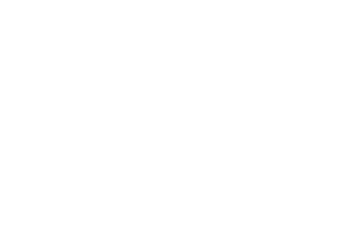

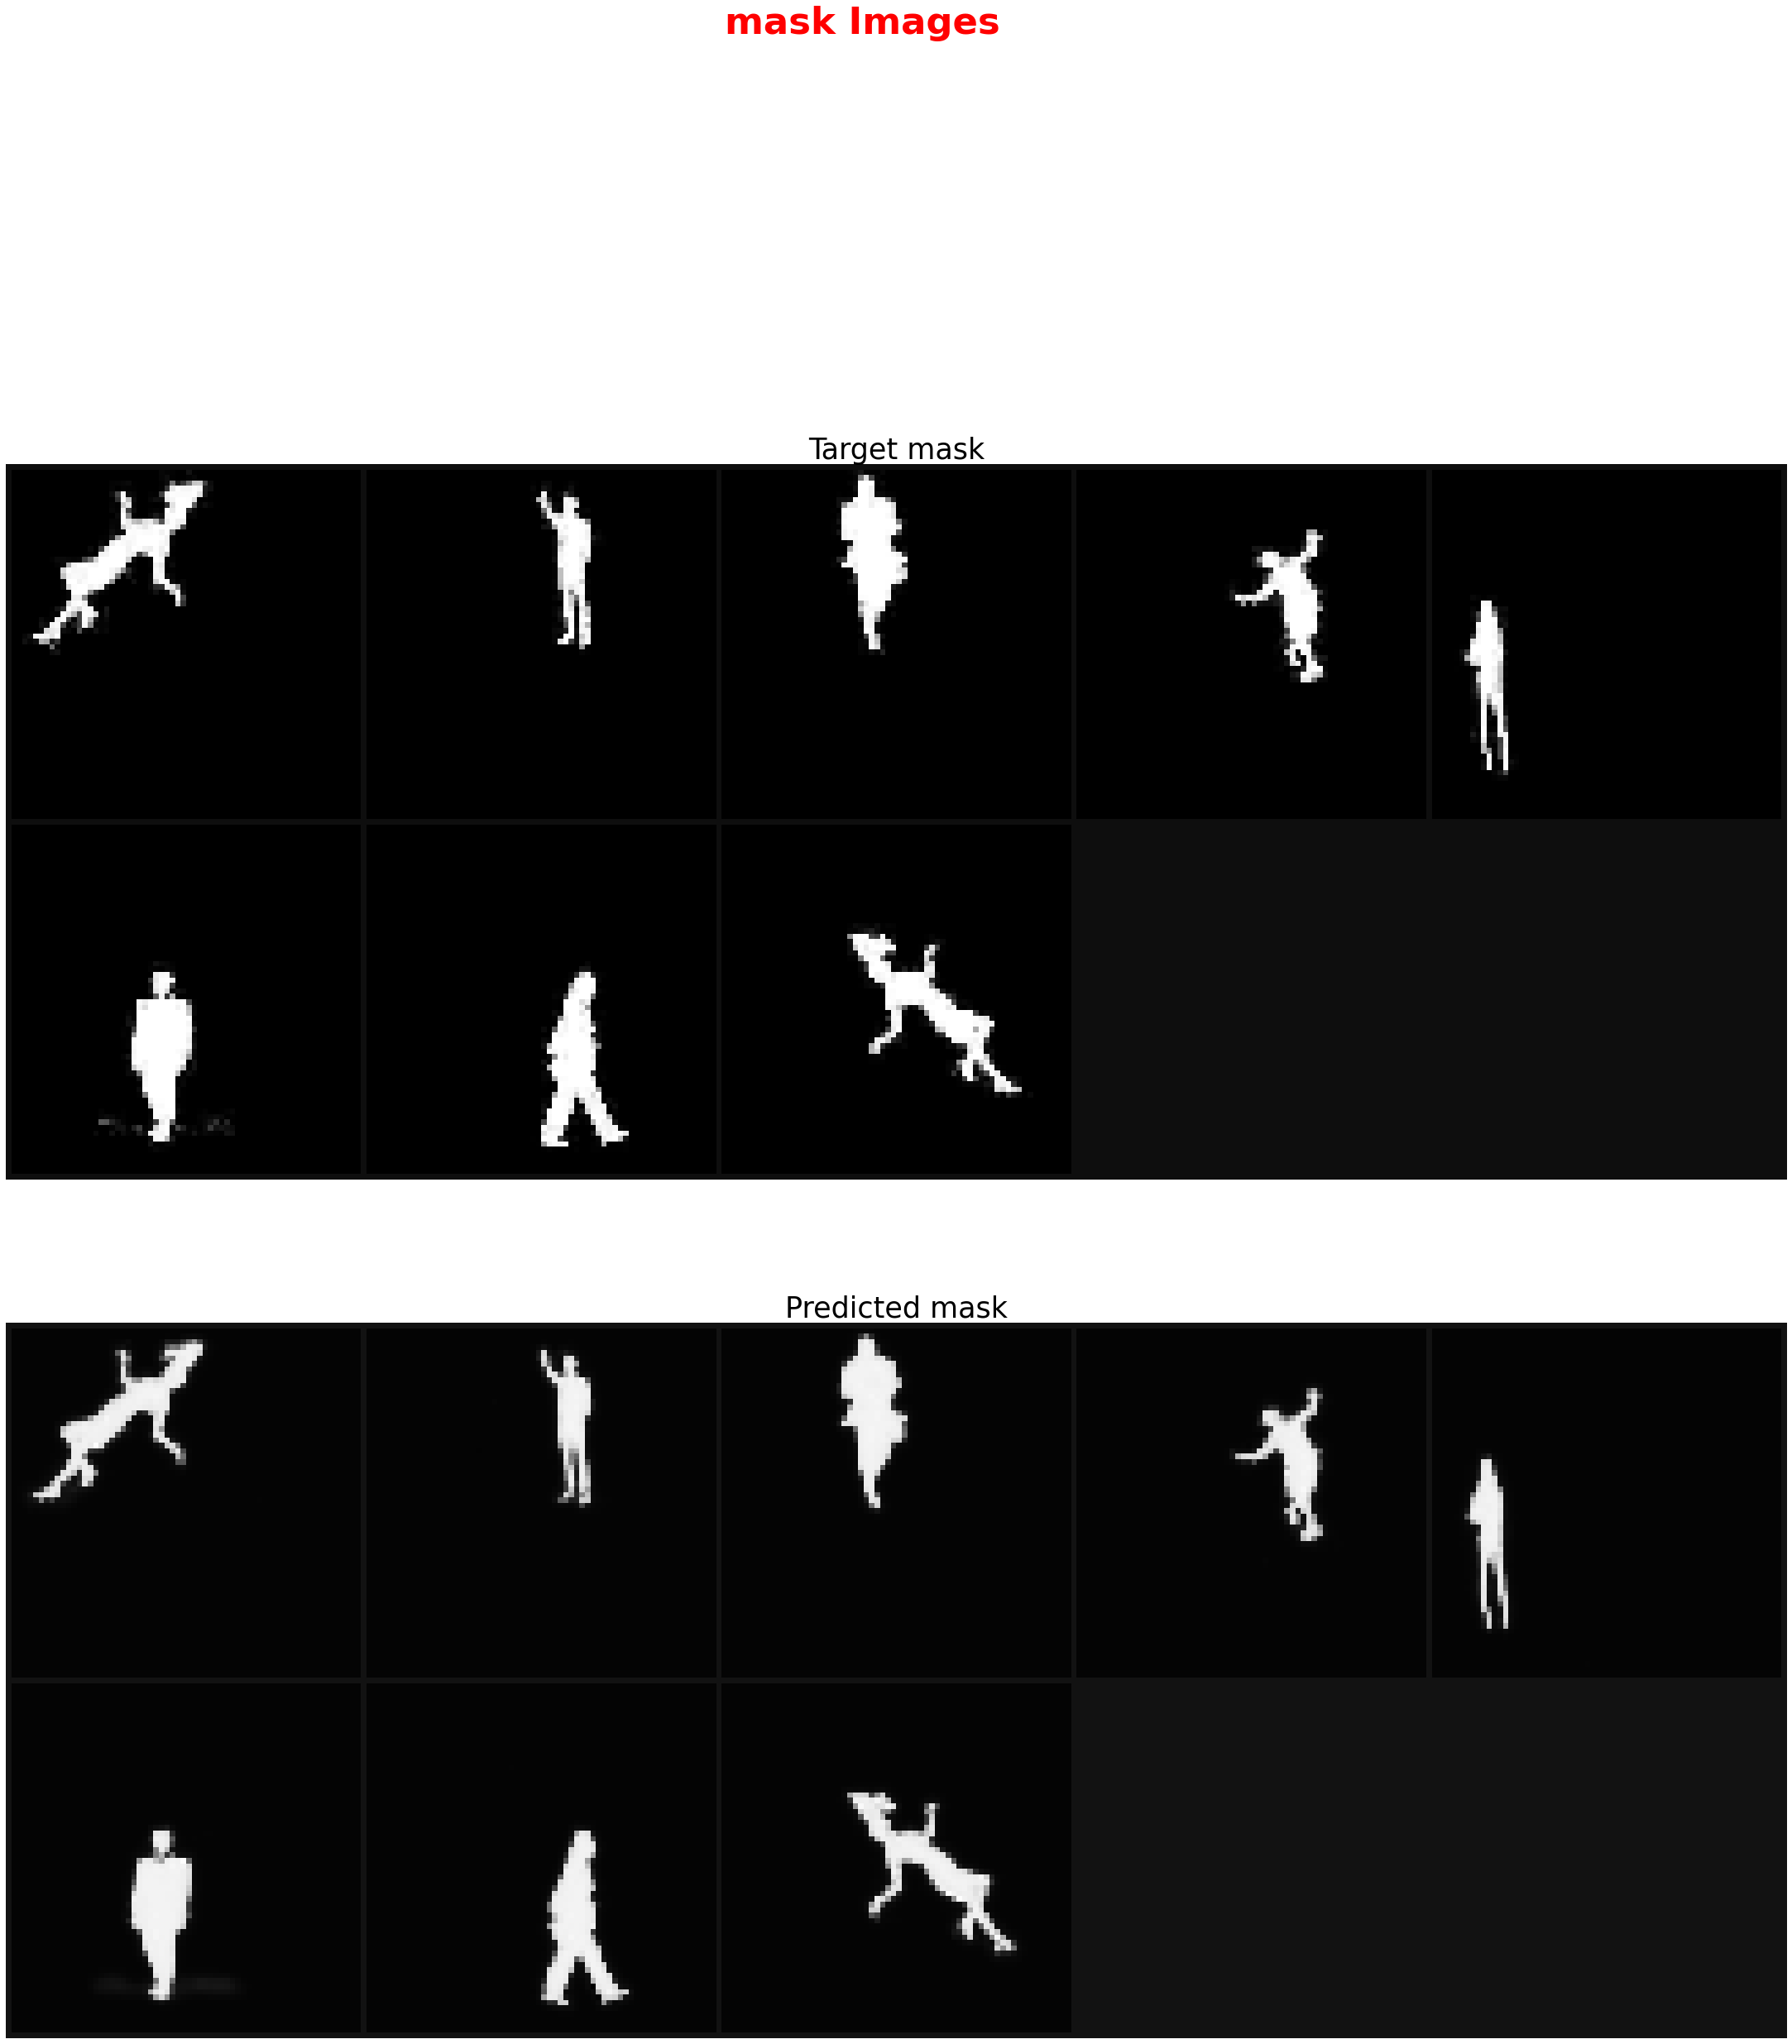

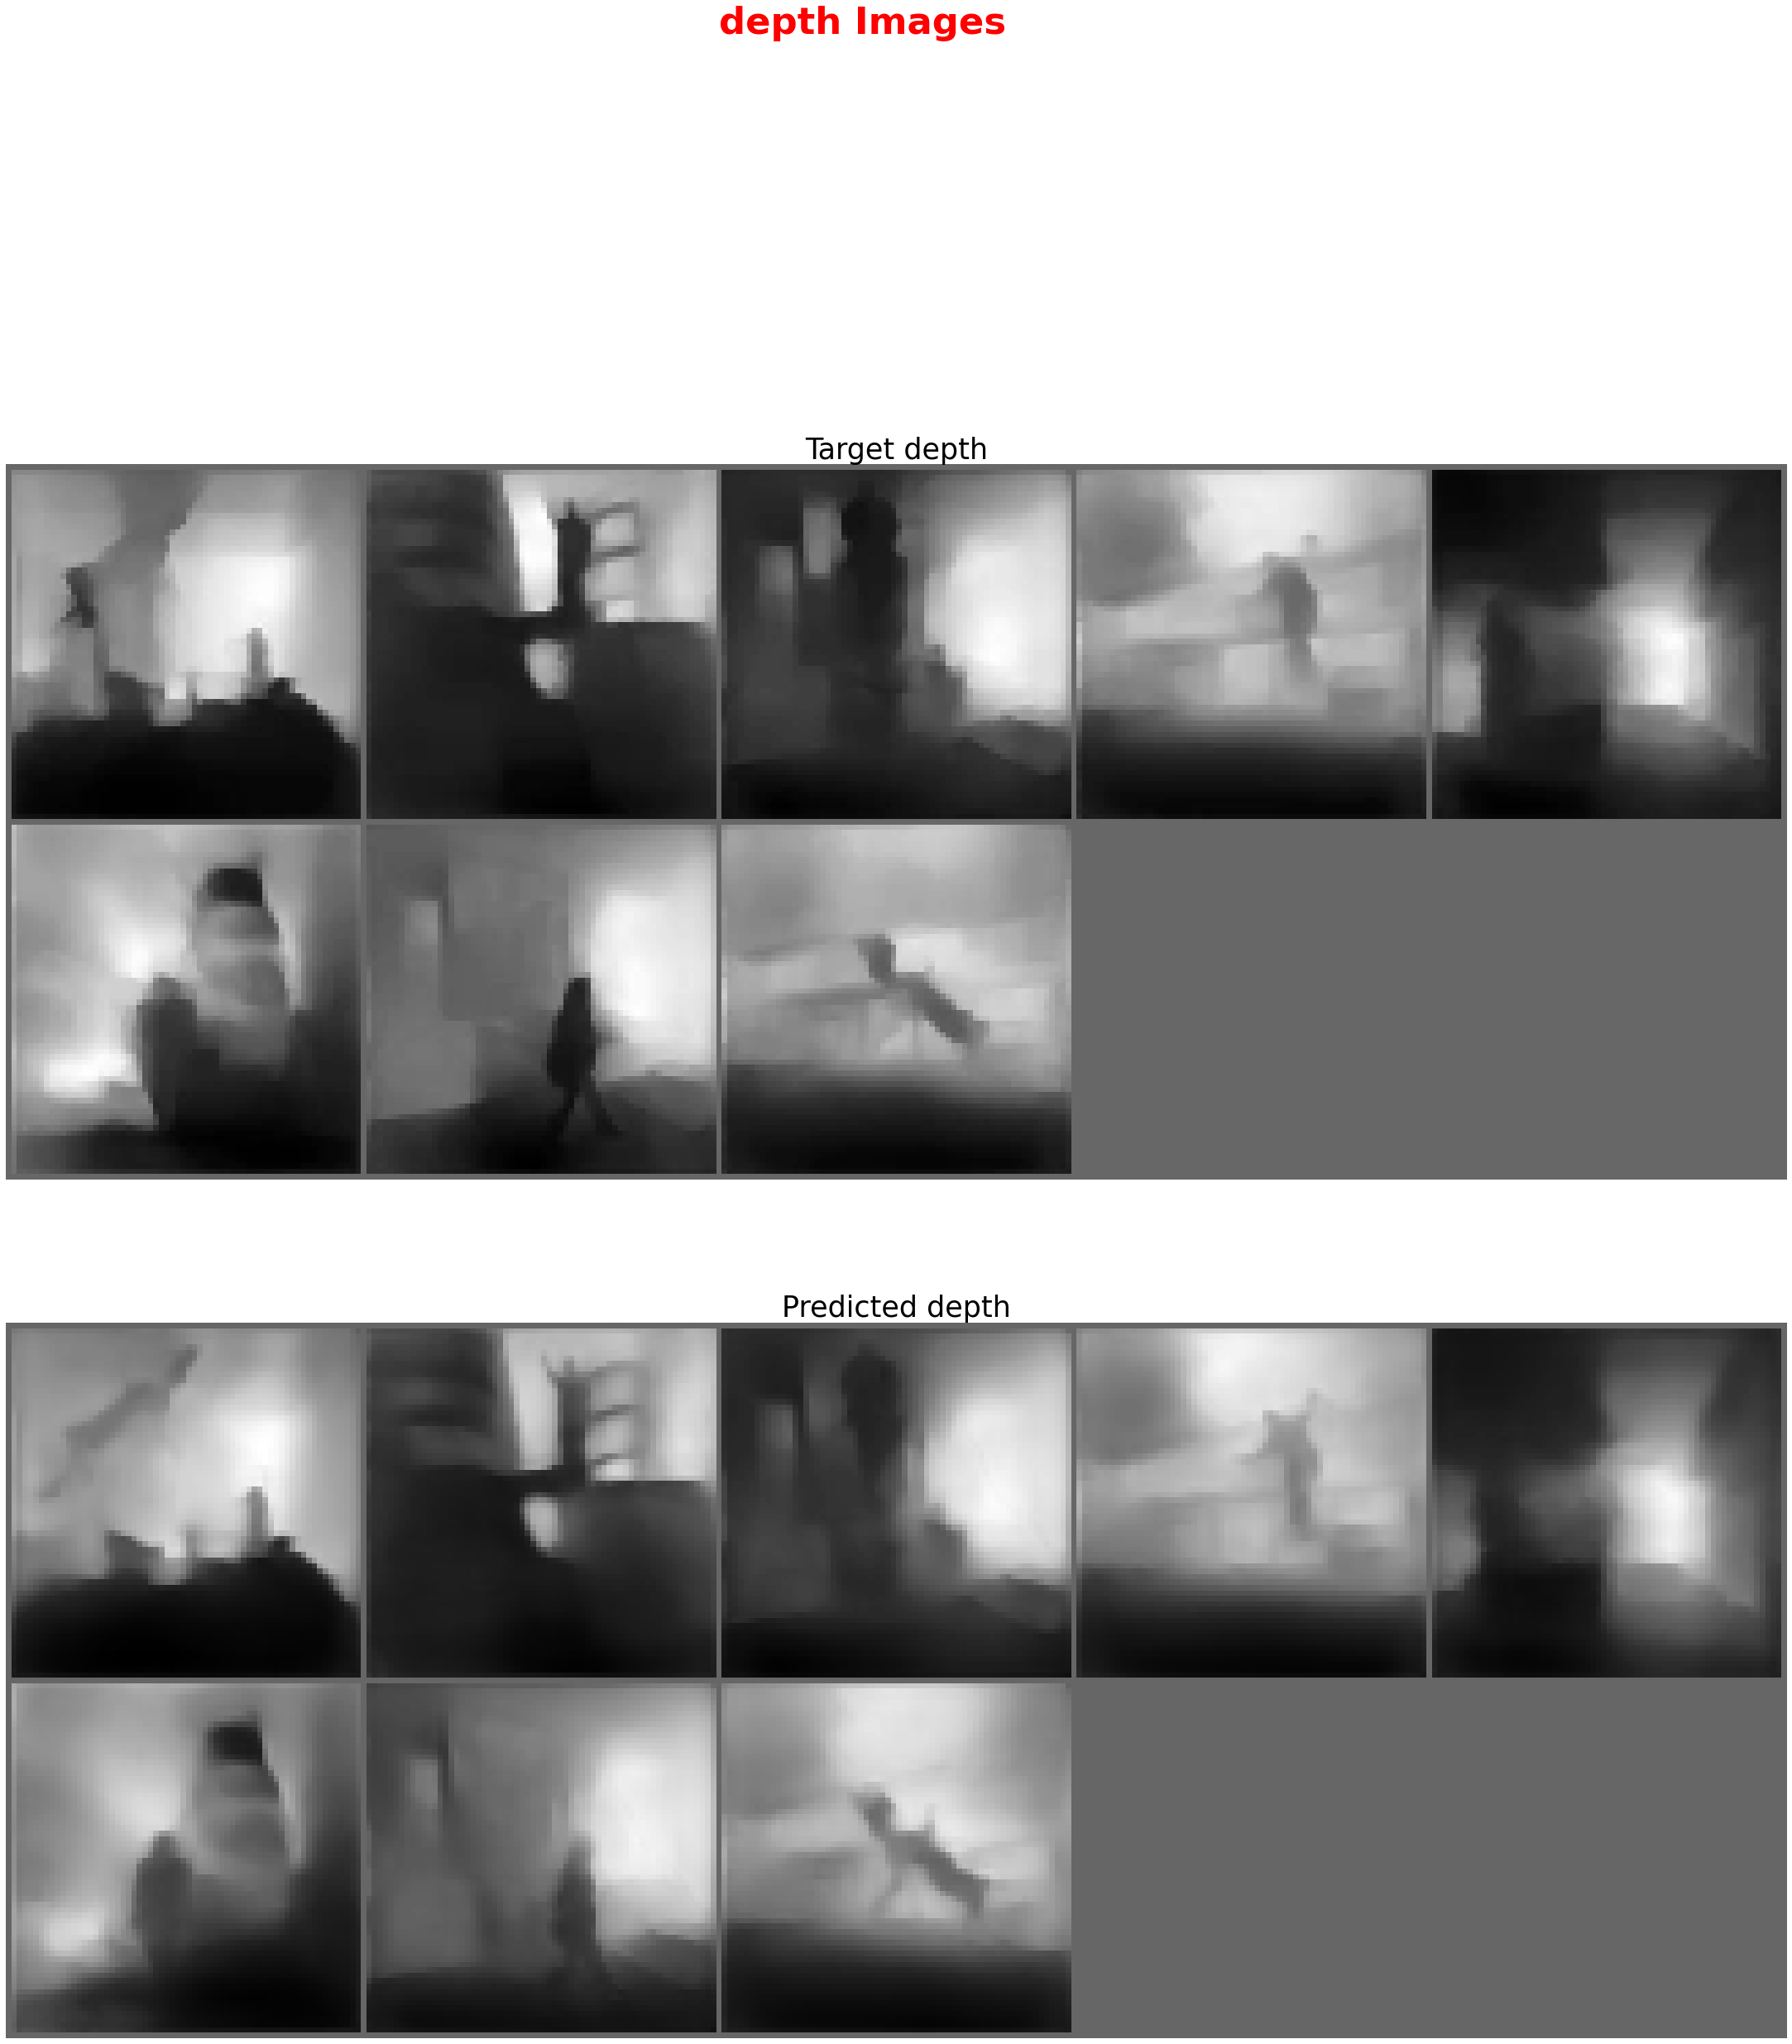

In [ ]:
display_results(model,test_loader,device, name = "Images")